# Video Inference - Task Classification

Process videos using a trained ResNet50 classifier to identify surgical tasks frame-by-frame.

## Pipeline
1. **Inference**: Sample every 30th frame, batch through ResNet50 with FP16 autocast. Frames are preprocessed with OpenCV (not PIL) and transferred to GPU as a single numpy batch for speed. Non-sampled frames are skipped with `grab()` to avoid decoding.
2. **Smoothing**: Symmetric confidence-weighted sliding window (15 frames centered). Each frame votes for its predicted class weighted by model confidence. Uses prefix sums for O(n) computation. This suppresses low-confidence noise without smearing task boundaries in one direction.
3. **Min duration enforcement**: Segments shorter than 5 seconds are iteratively merged into their longer neighbour. Uses segment length (not confidence) as the merge criterion so it cannot cascade.
4. **Aggregation**: Contiguous segments of the same task are collapsed into time ranges. Each segment ends exactly where the next begins (no gaps).

## Imports

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import cv2

import torch
from fastai.vision.all import *

import matplotlib.pyplot as plt


## Configuration

In [29]:
MODEL_PATH = "../../models/task_classifier.pkl"
VIDEO_PATH = "../../../datasets/videos/example5.avi"
OUTPUT_CSV_FRAMES = "task_detection_results.csv"
OUTPUT_CSV_RANGES = "task_detection_time_ranges.csv"

IMAGE_SIZE = (224, 224)
SAMPLE_EVERY_N_FRAMES = 30
TEMPORAL_SMOOTHING_WINDOW = 15
MIN_TASK_DURATION_SEC = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    available_mb = gpu_memory_gb * 1024 * 0.6  # use 60% of VRAM
    BATCH_SIZE = max(8, min(int((available_mb - 100) / 2.5), 128))
    print(f"GPU: {torch.cuda.get_device_name(0)} ({gpu_memory_gb:.1f}GB), Batch Size: {BATCH_SIZE}")
else:
    BATCH_SIZE = 16
    print("Using CPU, Batch Size: 16")


Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU (8.0GB), Batch Size: 128


## Load Model

In [30]:
inference_learn = load_learner(MODEL_PATH)
model = inference_learn.model
model.to(DEVICE)
model.eval()

CLASS_NAMES = list(inference_learn.dls.vocab)
N_CLASSES = len(CLASS_NAMES)

# Pre-compute on device once (avoids per-batch allocation)
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1, 3, 1, 1)
NORM_STD = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1, 3, 1, 1)

print(f"Model loaded: {MODEL_PATH}")
print(f"Classes: {CLASS_NAMES}")


c:\Users\meyer\OneDrive\Documents\Coding\UCL\Year 2\Systems\Data-Pipeline\.venv\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Model loaded: ../../models/task_classifier.pkl
Classes: ['CameraTarget', 'ChickenThigh', 'CystModel', 'GloveCut', 'Idle', 'MovingIndividualAxes', 'RingRollercoaster', 'SeaSpikes', 'Suture']


## Functions

In [ ]:
def format_timestamp(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = seconds % 60
    return f"{h:02d}:{m:02d}:{s:06.3f}"


def predict_batch(model, frames, device):
    if not frames:
        return []

    batch_np = np.empty((len(frames), IMAGE_SIZE[1], IMAGE_SIZE[0], 3), dtype=np.uint8)
    for i, frame in enumerate(frames):
        batch_np[i] = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), IMAGE_SIZE)

    batch = torch.from_numpy(np.ascontiguousarray(batch_np.transpose(0, 3, 1, 2)))
    batch = batch.to(device, dtype=torch.float32, non_blocking=True) / 255.0
    batch = (batch - NORM_MEAN) / NORM_STD

    with torch.no_grad(), torch.amp.autocast('cuda', enabled=device.type == 'cuda'):
        probs = torch.nn.functional.softmax(model(batch), dim=1)
        confs, preds = torch.max(probs, dim=1)

    return [(CLASS_NAMES[p.item()], c.item()) for p, c in zip(preds, confs)]


def process_video(video_path, model, device, sample_every=1, batch_size=32):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Processing: {video_path}")
    print(f"FPS: {fps:.2f}, Frames: {total_frames}, Duration: {format_timestamp(total_frames/fps)}")
    print(f"Batch size: {batch_size}\n")

    results = []
    frame_batch = []
    frame_nums = []
    frame_num = 0

    def flush_batch():
        if not frame_batch:
            return
        for fn, (task, conf) in zip(frame_nums, predict_batch(model, frame_batch, device)):
            results.append({
                'frame': fn,
                'time_sec': fn / fps,
                'time_str': format_timestamp(fn / fps),
                'task': task,
                'confidence': conf,
            })
        frame_batch.clear()
        frame_nums.clear()

    while cap.isOpened():
        # grab() advances without decoding — only retrieve() on sampled frames
        if not cap.grab():
            break

        if frame_num % sample_every == 0:
            ret, frame = cap.retrieve()
            if ret:
                frame_batch.append(frame)
                frame_nums.append(frame_num)

                if len(frame_batch) >= batch_size:
                    flush_batch()
                    if len(results) % 500 == 0:
                        print(f"  Frame {frame_num}/{total_frames} ({100*frame_num/total_frames:.1f}%)")

        frame_num += 1

    flush_batch()
    cap.release()
    print(f"Done: {len(results)} frames processed\n")
    return pd.DataFrame(results)


def smooth_predictions(df, smoothing_window=15):
    if len(df) == 0:
        return df

    tasks = df['task'].tolist()
    confidences = df['confidence'].values
    n = len(tasks)
    half = smoothing_window // 2
    task_to_idx = {t: i for i, t in enumerate(CLASS_NAMES)}

    # Sparse confidence matrix — only one class has a non-zero value per frame
    scores = np.zeros((n, N_CLASSES), dtype=np.float32)
    for i, (task, conf) in enumerate(zip(tasks, confidences)):
        scores[i, task_to_idx[task]] = conf

    # Prefix sums for O(n) symmetric sliding window
    prefix = np.zeros((n + 1, N_CLASSES), dtype=np.float32)
    np.cumsum(scores, axis=0, out=prefix[1:])

    starts = np.maximum(0, np.arange(n) - half)
    ends = np.minimum(n, np.arange(n) + half + 1)
    window_sums = prefix[ends] - prefix[starts]

    best_indices = np.argmax(window_sums, axis=1)
    smoothed = [CLASS_NAMES[idx] for idx in best_indices]

    df = df.copy()
    df['task_smoothed'] = smoothed
    return df


def enforce_min_duration(df, min_duration_sec=5):
    if len(df) < 2:
        return df

    tasks = df['task_smoothed'].tolist()
    times = df['time_sec'].tolist()

    # Iteratively merge the shortest sub-minimum segment into its longer neighbour
    changed = True
    while changed:
        changed = False

        segments = []
        start = 0
        for i in range(1, len(tasks)):
            if tasks[i] != tasks[start]:
                segments.append((start, i - 1))
                start = i
        segments.append((start, len(tasks) - 1))

        for seg_idx, (s, e) in enumerate(segments):
            if times[e] - times[s] >= min_duration_sec:
                continue

            left_dur = -1
            right_dur = -1

            if seg_idx > 0:
                ls, le = segments[seg_idx - 1]
                left_dur = times[le] - times[ls]

            if seg_idx < len(segments) - 1:
                rs, re = segments[seg_idx + 1]
                right_dur = times[re] - times[rs]

            if left_dur >= right_dur and left_dur >= 0:
                merge_task = tasks[segments[seg_idx - 1][0]]
            elif right_dur >= 0:
                merge_task = tasks[segments[seg_idx + 1][0]]
            else:
                continue

            for i in range(s, e + 1):
                tasks[i] = merge_task
            changed = True
            break  # restart after each merge

    df = df.copy()
    df['task_smoothed'] = tasks
    return df


def aggregate_time_ranges(df):
    if len(df) == 0:
        return pd.DataFrame()

    ranges = []
    current_task = df.iloc[0]['task_smoothed']
    start_time = df.iloc[0]['time_sec']
    confidences = [df.iloc[0]['confidence']]

    for i in range(1, len(df)):
        row = df.iloc[i]
        if row['task_smoothed'] != current_task:
            # End at the next segment's start so segments are contiguous
            end_time = row['time_sec']
            ranges.append({
                'task': current_task,
                'start': format_timestamp(start_time),
                'end': format_timestamp(end_time),
                'duration_sec': end_time - start_time,
                'avg_conf': np.mean(confidences)
            })
            current_task = row['task_smoothed']
            start_time = end_time
            confidences = [row['confidence']]
        else:
            confidences.append(row['confidence'])

    ranges.append({
        'task': current_task,
        'start': format_timestamp(start_time),
        'end': format_timestamp(df.iloc[-1]['time_sec']),
        'duration_sec': df.iloc[-1]['time_sec'] - start_time,
        'avg_conf': np.mean(confidences)
    })

    return pd.DataFrame(ranges)

## Pipeline

In [32]:
if os.path.exists(VIDEO_PATH):
    results_df = process_video(VIDEO_PATH, model, DEVICE,
                               sample_every=SAMPLE_EVERY_N_FRAMES,
                               batch_size=BATCH_SIZE)
    results_df = smooth_predictions(results_df, smoothing_window=TEMPORAL_SMOOTHING_WINDOW)
    results_df = enforce_min_duration(results_df, min_duration_sec=MIN_TASK_DURATION_SEC)
    print(results_df.head())
else:
    print(f"Video not found: {VIDEO_PATH}")


Processing: ../../../datasets/videos/example5.avi
FPS: 30.00, Frames: 3370, Duration: 00:01:52.333
Batch size: 128

Done: 113 frames processed

   frame  time_sec      time_str       task  confidence task_smoothed
0      0       0.0  00:00:00.000  SeaSpikes    0.473381     SeaSpikes
1     30       1.0  00:00:01.000  SeaSpikes    0.815747     SeaSpikes
2     60       2.0  00:00:02.000  SeaSpikes    0.858025     SeaSpikes
3     90       3.0  00:00:03.000  SeaSpikes    0.785815     SeaSpikes
4    120       4.0  00:00:04.000  SeaSpikes    0.511151     SeaSpikes


## Aggregate Time Ranges

In [33]:
if 'results_df' in locals():
    time_ranges = aggregate_time_ranges(results_df)
    print("\nTask Time Ranges:")
    print(time_ranges.to_string(index=False))



Task Time Ranges:
     task        start          end  duration_sec  avg_conf
SeaSpikes 00:00:00.000 00:01:34.000          94.0  0.708172
     Idle 00:01:35.000 00:01:52.000          17.0  0.689394


## Export Results

In [34]:
if 'results_df' in locals():
    results_df.to_csv(OUTPUT_CSV_FRAMES, index=False)
    print(f"Saved: {OUTPUT_CSV_FRAMES}")
if 'time_ranges' in locals():
    time_ranges.to_csv(OUTPUT_CSV_RANGES, index=False)
    print(f"Saved: {OUTPUT_CSV_RANGES}")


Saved: task_detection_results.csv
Saved: task_detection_time_ranges.csv


## Visualise Timeline

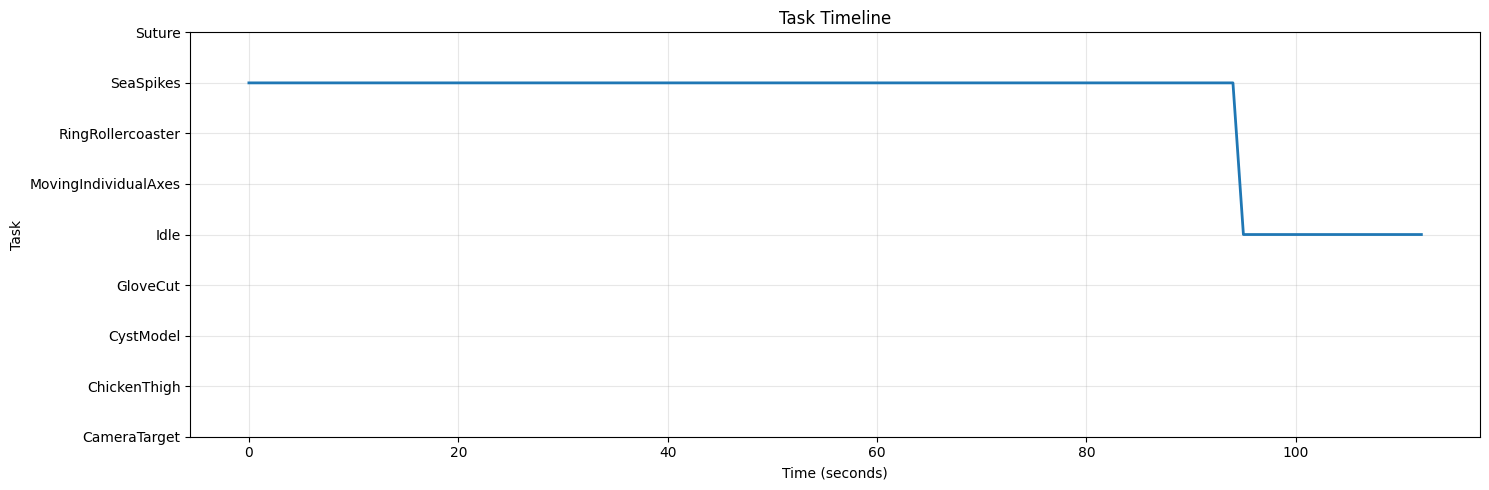

In [35]:
if 'results_df' in locals() and len(results_df) > 0:
    fig, ax = plt.subplots(figsize=(15, 5))
    task_to_idx = {task: i for i, task in enumerate(CLASS_NAMES)}
    task_indices = [task_to_idx[t] for t in results_df['task_smoothed']]
    ax.plot(results_df['time_sec'], task_indices, linewidth=2)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Task')
    ax.set_yticks(range(len(CLASS_NAMES)))
    ax.set_yticklabels(CLASS_NAMES)
    ax.set_title('Task Timeline')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Task Duration Summary

In [36]:
if 'time_ranges' in locals() and len(time_ranges) > 0:
    summary = time_ranges.groupby('task')['duration_sec'].sum().sort_values(ascending=False)
    total_time = summary.sum()
    print("\nTask Duration Summary:")
    for task, duration in summary.items():
        pct = 100 * duration / total_time
        print(f"  {task:20s}: {duration:7.1f}s ({pct:5.1f}%)")



Task Duration Summary:
  SeaSpikes           :    94.0s ( 84.7%)
  Idle                :    17.0s ( 15.3%)
